In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from scipy.fftpack import dct
from scipy.fftpack import idct

import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot


 #### -- 모델 준비

In [2]:
# 원전 내부의 충돌체 정보를 네개의 센서 정보만으로 특정해내기
# 데이터 출처 : https://dacon.io/competitions/official/235614/overview/description/
train_features = pd.read_csv('D:/Data/KAERI_dataset/train_features.csv')
train_target = pd.read_csv('D:/Data/KAERI_dataset/train_target.csv')



In [3]:
train_features.shape, train_target.shape



((1050000, 6), (2800, 5))

In [4]:
train_features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [5]:
def pick_peak(data0):
	data = data0.copy()
	for sensor in ['S1','S2','S3','S4']:
		data[sensor+'_peak'] = -((data[sensor].shift(1)-data[sensor])/abs(data[sensor].shift(1)-data[sensor])+(data[sensor].shift(-1)-data[sensor])/abs(data[sensor].shift(-1)-data[sensor]))/2
		data = data.fillna(0)
		# for i in data['id']:
		# 	last = data[data['id']==0].index[-1]
		# 	data.loc[last,sensor+'_peak'] = 0

	return data

In [6]:
def first_max_gap(data):
    peak_df = pick_peak(data)
    peak_s_list = []
    for s in ['S1','S2','S3','S4']:
        peak_s = peak_df.copy()
        peak_s = peak_s[peak_s[s+'_peak']!=0][['id',s,s+'_peak']]
        peak_s[s+'_up'] = peak_s[s].shift(-1)
        peak_s['g_'+s] = peak_s[s]*peak_s[s+'_peak']+peak_s[s+'_up']*peak_s[s+'_peak']*(-1)
        peak_s = peak_s[['id','g_'+s]].dropna()
        peak_s['g_'+s+'_peak'] = -((peak_s['g_'+s].shift(1)-peak_s['g_'+s])/abs(peak_s['g_'+s].shift(1)-peak_s['g_'+s])+(peak_s['g_'+s].shift(-1)-peak_s['g_'+s])/abs(peak_s['g_'+s].shift(-1)-peak_s['g_'+s]))/2
        peak_s = peak_s.fillna(0)
        peak_s['fm_gap_'+s] = peak_s['g_'+s]*peak_s['g_'+s+'_peak']
        peak_s = peak_s[peak_s['fm_gap_'+s]>peak_s['fm_gap_'+s].mean()][['id','fm_gap_'+s]].drop_duplicates(['id'],keep='first')
        peak_s = peak_s.reset_index()[['fm_gap_'+s]]
        peak_s_list.append(peak_s)
    peak_df = pd.concat(peak_s_list,axis=1)
    return peak_df

In [7]:
def first_max_gap_interval(data):
    peak_df = pick_peak(data)
    peak_s_list = []
    for s in ['S1','S2','S3','S4']:
        peak_s = peak_df.copy()
        peak_s = peak_s[peak_s[s+'_peak']!=0][['id','Time',s,s+'_peak']]
        peak_s[s+'_up'] = peak_s[s].shift(-1)
        peak_s[s+'_time_up'] = peak_s['Time'].shift(-1)
        peak_s['g_'+s] = peak_s[s]*peak_s[s+'_peak']+peak_s[s+'_up']*peak_s[s+'_peak']*(-1)
        peak_s['intv_'+s] = abs(peak_s['Time']-peak_s[s+'_time_up'])*10**6
        peak_s = peak_s[['id','g_'+s,'intv_'+s]].dropna()
        peak_s['g_'+s+'_peak'] = -((peak_s['g_'+s].shift(1)-peak_s['g_'+s])/abs(peak_s['g_'+s].shift(1)-peak_s['g_'+s])+(peak_s['g_'+s].shift(-1)-peak_s['g_'+s])/abs(peak_s['g_'+s].shift(-1)-peak_s['g_'+s]))/2
        peak_s = peak_s.fillna(0)
        peak_s['fm_gap_'+s] = peak_s['g_'+s]*peak_s['g_'+s+'_peak']
        peak_s['fm_intv_'+s] = peak_s['intv_'+s]*peak_s['g_'+s+'_peak']
        peak_s = peak_s[peak_s['fm_gap_'+s]>peak_s['fm_gap_'+s].mean()][['id','fm_gap_'+s,'fm_intv_'+s]].drop_duplicates(['id'],keep='first')
        peak_s = peak_s.reset_index()[['fm_gap_'+s,'fm_intv_'+s]]
        peak_s['delta_'+s] = peak_s['fm_gap_'+s]/peak_s['fm_intv_'+s]
        peak_s = peak_s[['fm_gap_'+s,'delta_'+s]]
        peak_s_list.append(peak_s)
    peak_df = pd.concat(peak_s_list,axis=1)
    return peak_df

In [8]:
def find_firt_min_amp(data0,min_amp=937.55):
    data = data0.copy()
    cond_min = (np.abs(data['S1']) > min_amp) | (np.abs(data['S2']) > min_amp) | (np.abs(data['S3']) > min_amp) | (np.abs(data['S4']) > min_amp)
    data_active = data[cond_min]
    data_active = data_active.drop_duplicates(['id'],keep='first')

    return data_active


In [9]:
# scipy에서 Discrete Cosine Transform을 사용, 원하는 만큼만 잘라낼 수 있게 함수 설정
def fourier_trsf(data,sensor,idx=10,cutoff=65):
	cond_id = data['id']==idx
	wave = data.loc[cond_id,sensor].values
	time = data.loc[cond_id,'Time']
	fft_wave = dct(wave, type=2,n=time.shape[0],norm='ortho')
	freq = np.fft.fftfreq(wave.size,d=0.000004)
	cw = np.copy(fft_wave)
	cw[cutoff:]=0
	fft_wave_2 = np.real(idct(cw,norm='ortho'))
	
	return {"cw":cw[:cutoff],"fft":fft_wave, "freq":freq, "fft_cutoff":fft_wave_2, "time":time, "wave":wave}


In [10]:

def find_unique_freq(data0,head=40):
    data = data0.copy()
    id_list = np.array(data['id'].unique())
    set_dict = {}
    n = data[data['id']==0].shape[0]
    nn = int(n/2)+1

    for s in ['S1','S2','S3','S4']:
        min_set = set(range(0,nn))
        for i in id_list:
            fft_wave = fourier_trsf(data=data,sensor=s,id=i)
            freq = fft_wave['freq'][0:nn]
            amp = fft_wave['fft'][0:nn]
            abs_amp = abs(amp)

            df_wave = pd.DataFrame([freq,amp,abs_amp]).T
            df_wave.columns = ['freq','amp','abs_amp']
            set_i = set(df_wave.sort_values(by='abs_amp',ascending=False).head(head).index)

            min_set = min_set - set_i

        set_dict[s]=min_set
    return set_dict


In [11]:
# 65번째 까지(0~64) 킵해보자
# 일단 feature로 만들어서 넣어주는 함수를 짜자
# column이름은 f1_0~f4_65같은 식으로 넣기
def fourier_feature(data0,cutoff=65):
    data = data0.copy()
    id_list = np.array(data['id'].unique())
    df_id = pd.DataFrame(id_list,columns=['id'])
    df_list = [df_id]

    for s in ['S1','S2','S3','S4']:
        df_s = []
        for i in id_list:
            fft_wave = fourier_trsf(data=data,sensor=s,idx=i,cutoff=cutoff)
            amp = fft_wave['cw']
            
            df_wave = pd.DataFrame(amp).T
            df_wave.columns = [s+'_f'+str(n) for n in range(cutoff)]
            df_s.append(df_wave)
        df_sensor = pd.concat(df_s,axis=0).reset_index(drop=True)
        df_list.append(df_sensor)

    df_tot = pd.concat(df_list,axis=1)

    return df_tot


In [12]:
# 확인 해보니, S3가 먼저 신호를 받은 경우가 한번도 없는 것으로 나온다
# 그래서 S3가 항상 고려되지 않은채로 분류 된 것...
# 추후에도 S3값이 고려 될 수 있게, 축을 새로 잡아주기
def reset_axis(data0,new_axis=('A','B','C','D')):
    data = data0.copy()
    
    # A=(S1+S2+S3+S4)/4, B=(S1+S2-S3-S4)/4, C=(S1-S2-S3+S4)/4, D=(S1-S2+S3-S4)/4
    ns1,ns2,ns3,ns4 = data['S1'],data['S2'],data['S3'],data['S4']
    data[new_axis[0]] = (ns1+ns2+ns3+ns4)/4
    data[new_axis[1]] = (ns1+ns2-ns3-ns4)/4
    data[new_axis[2]] = (ns1-ns2-ns3+ns4)/4
    data[new_axis[3]] = (ns1-ns2+ns3-ns4)/4
    data = data.drop(['Time','S1','S2','S3','S4'],axis=1)
    
    return data


In [13]:
# 앞서 수행했던 데이터 전처리 및 feature engineering을 수행해주는 함수
def feature_eng_df(data,cutoff=80):   
    cond_0 = (data['S1'] != 0) | (data['S2'] != 0) | (data['S3'] != 0) | (data['S4'] != 0)
    data_active = data[cond_0]
    data_active = data_active.drop_duplicates(['id'],keep='first')
    
    new_axis = ('A','B','C','D')
    data_new = reset_axis(data,new_axis=new_axis)
    cond_new = (data_new['A'] != 0) | (data_new['B'] != 0) | (data_new['C'] != 0) | (data_new['D'] != 0)  
    data_active_new = data_new[cond_new]
    data_active_new = data_active_new.drop_duplicates(['id'],keep='first')
    
    data_active = data_active.merge(data_active_new,on='id')
    
    for s in ['S1','S2','S3','S4']:
        min_s = data.groupby(by='id').min()[s]
        max_s = data.groupby(by='id').max()[s]
        gap_s = max_s - min_s
        gap_s = gap_s.reset_index()
        gap_s.columns = ['id','gap_'+s]
        data_active = data_active.merge(gap_s,on='id')

    gap_data = first_max_gap_interval(data)
    data_active = pd.concat([data_active,gap_data],axis=1)

    data_active['Time'] = (data_active['Time']*10**6).astype('int')

    data[(data['S2'] != 0)].drop_duplicates(['id'],keep='first')[['id','Time']]

    for s in ['S1','S2','S3','S4']:
        cond_t = (data[s] != 0)
        active_time = data[cond_t].drop_duplicates(['id'],keep='first')[['id','Time']]
        active_time['Time'] = (active_time['Time']*10**6).astype('int')
        active_time.columns = ['id','active_time_'+s]
        data_active = data_active.merge(active_time,on='id')

    data_active['R12'] = (data_active['active_time_S1']+data_active['active_time_S2'])/(data_active['active_time_S3']+data_active['active_time_S4'])
    data_active['R13'] = (data_active['active_time_S1']+data_active['active_time_S3'])/(data_active['active_time_S2']+data_active['active_time_S4'])
    data_active['R14'] = (data_active['active_time_S1']+data_active['active_time_S4'])/(data_active['active_time_S2']+data_active['active_time_S3'])

    data_active['RMS_S'] = (data_active['S1']**2+data_active['S2']**2+data_active['S3']**2+data_active['S4']**2)**0.5
    data_active['RMS_gap'] = (data_active['gap_S1']**2+data_active['gap_S2']**2+data_active['gap_S3']**2+data_active['gap_S4']**2)**0.5
    data_active['RMS_fm_gap'] = (data_active['fm_gap_S1']**2+data_active['fm_gap_S2']**2+data_active['fm_gap_S3']**2+data_active['fm_gap_S4']**2)**0.5
    data_active['RMS_delta'] = (data_active['delta_S1']**2+data_active['delta_S2']**2+data_active['delta_S3']**2+data_active['delta_S4']**2)**0.5
    data_active['RMS_time'] = (data_active['active_time_S1']**2+data_active['active_time_S2']**2+data_active['active_time_S3']**2+data_active['active_time_S4']**2)**0.5
    
    data_fft = fourier_feature(data,cutoff=cutoff)
    data_active = data_active.merge(data_fft,on='id')

    return data_active



In [14]:
# dacon에서 제공하는 평가 지표 함수. 낮을 수록 좋은 값.
def kaeri_metric(y_true, y_pred):    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)

def E1(y_true, y_pred):
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

def E2(y_true, y_pred):
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]           
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

In [15]:
def cv_check(data,target,features,params,cv=5):
    model = lgb.LGBMRegressor(**params)

    data_feature = data[features] 
    data_target = data[target]

    cv_score = cross_validate(model,data_feature,data_target,cv=cv,scoring=('neg_root_mean_squared_error','neg_mean_absolute_error'))

    rmse = -cv_score['test_neg_root_mean_squared_error'] 
    mae = -cv_score['test_neg_mean_absolute_error']

    return {'mean_rmse':rmse.mean(),'std_rmse':rmse.std(),'mean_mae':mae.mean(),'std_mae':mae.std()}


In [16]:
def make_model(data,test_data,target,features,params):
    model = lgb.LGBMRegressor(**params)

    data_feature = data[features] 
    data_target = data[target]

    test_data_feature = test_data[features] 

    model.fit(data_feature,data_target)
    test_pred = model.predict(test_data_feature)

    return test_pred, model


In [17]:
def multi_model(data,test_data,submit0,x_feature,y_feature,m_feature,v_feature,x_params,y_params,m_params,v_params):
    pred_x, model_x = make_model(data,test_data,'X',x_feature,x_params)
    pred_y, model_y = make_model(data,test_data,'Y',y_feature,y_params)
    pred_m, model_m = make_model(data,test_data,'M',m_feature,m_params)
    pred_v, model_v = make_model(data,test_data,'V',v_feature,v_params)

    submit = submit0.copy()

    submit['X'] = pred_x
    submit['Y'] = pred_y
    submit['M'] = pred_m
    submit['V'] = pred_v

    return {'submit':submit,'X':model_x,'Y':model_y,'M':model_m,'V':model_v}

In [18]:
def cutoff_features(data,cutoff):
    feature_list = list(data.loc[:,'Time':'RMS_time'].columns) 
    if cutoff > 0:
        for s in ['S1','S2','S3','S4']:
            feature_list = feature_list+[s+'_f'+str(n) for n in range(cutoff)]
    return feature_list    


In [19]:
def find_opt_cutoff(target_col,target_params,train_data,target_data,min_c=10,max_c=100,step_c=5,cv=5):
    data=train_data.copy()
    data_features = feature_eng_df(data,cutoff=max_c)
    data_tot = data_features.merge(target_data,on='id')
    data_train_val, _ = train_test_split(data_tot[1:],test_size=0.2,train_size=0.8,random_state=2)
    cv_dict = {}
    min_rmse = 999
    opt_cutoff = None

    for nn in range(min_c,max_c+step_c,step_c):       
        feature_list = list(data_features.loc[:,'Time':'RMS_time'].columns)  
        for s in ['S1','S2','S3','S4']:
            feature_list = feature_list+[s+'_f'+str(n) for n in range(nn)]
        cv_result = cv_check(data_train_val,target_col,feature_list,target_params,cv=cv)
        rmse_upper = cv_result['mean_rmse']+cv_result['std_rmse']
        cv_dict[nn]={'rmse_upper':rmse_upper,'mean_rmse':cv_result['mean_rmse'],'mean_mae':cv_result['mean_mae']}
        if min_rmse > rmse_upper:
            min_rmse = rmse_upper
            opt_cutoff = nn
        
    return {'opt_cutoff':opt_cutoff,'rmse_upper':min_rmse},cv_dict

In [20]:
def cv_multi_model(data,x_feature,y_feature,m_feature,v_feature,x_params,y_params,m_params,v_params):
    kf = KFold(n_splits=5)
    mae_score_list = []
    rmse_score_list = []
    for train_index, test_index in kf.split(data):
        train_d = data.iloc[train_index]
        test_d = data.iloc[test_index]
        test_pred = multi_model(train_d,test_d,test_d[targets],x_feature,y_feature,m_feature,v_feature,x_params,y_params,m_params,v_params)['submit']
        mae_score = mean_absolute_error(test_d[targets],test_pred)
        rmse_score = mean_squared_error(test_d[targets],test_pred)**0.5
        mae_score_list.append(mae_score)
        rmse_score_list.append(rmse_score)
    return {'mae_mean':np.mean(mae_score_list),'rmse_mean':np.mean(rmse_score_list)}

In [21]:
select_objective = 'regression'
boosting_type = 'dart'
learning_rate = [0.21,0.36,0.2,0.25]

x_params = {'learning_rate':learning_rate[0],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}
y_params = {'learning_rate':learning_rate[1],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}
m_params = {'learning_rate':learning_rate[2],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}
v_params = {'learning_rate':learning_rate[3],'n_estimators':1000,
    'boosting_type':boosting_type,'random_state':2,'objective':select_objective
}

In [22]:
%%time
cutoff = 80
df_features = feature_eng_df(train_features,cutoff=cutoff)

targets = list(train_target.columns)[1:]
features = list(df_features.columns)[1:]

df = df_features.merge(train_target,on='id')

# 데이터를 학습용, 검증용으로 분리
df_train_val, df_test = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)
df_train, df_val = train_test_split(df_train_val,test_size=0.2,train_size=0.8,random_state=2)

print(df_train.shape, df_val.shape, df_test.shape, df.shape)

simple_features = np.array(df.loc[:,'Time':'RMS_time'].columns)
m_features = cutoff_features(df,cutoff=35)
v_features = cutoff_features(df,cutoff=70)

print(len(simple_features))

cv_multi_model(
    df_train_val,x_feature=simple_features,y_feature=simple_features,
    m_feature=m_features,v_feature=v_features,
    x_params=x_params,y_params=y_params,m_params=m_params,v_params=v_params
    )
#(선택) cutoff 50, fft M에만, RMS_fm_gap, RMS_delta 추가 : 'mae_mean': 1.7325866284149363, 'rmse_mean': 4.450483257720237
# cutoff 50, fft M에만, RMS_delta 추가 : 'mae_mean': 1.7390971725055941, 'rmse_mean': 4.458978638748245
# cutoff 50, RMS_delta 추가 : 'mae_mean': 1.7392360948471122, 'rmse_mean': 4.458978489204364
# cutoff 50, RMS_fm_gap, RMS_delta 추가 : 'mae_mean': 1.7327434751083626, 'rmse_mean': 4.450483285571538
# fft 제외, RMS_delta 추가 :'mae_mean': 2.0340186385173507, 'rmse_mean': 5.4929653359612125
# fft 제외, RMS_fm_gap, RMS_delta 추가 : 'mae_mean': 1.969271026745498, 'rmse_mean': 5.426859158588782
# fft M에만, RMS_fm_gap, RMS_delta 추가 :  'mae_mean': 1.7582579805532994, 'rmse_mean': 4.567569738723604
# 기본 : 'mae_mean': 1.7822870485423103, 'rmse_mean': 4.624290787675408
# RMS_fm_gap 추가 : 'mae_mean': 1.7901232913446699, 'rmse_mean': 4.646975811636593
# RMS_delta 추가 : 'mae_mean': 1.761043290357069, 'rmse_mean': 4.551973492153343
# RMS_fm_gap, RMS_delta 추가 : 'mae_mean': 1.7584043605059432, 'rmse_mean': 4.567569904422059

(1791, 358) (448, 358) (560, 358) (2800, 358)
33
Wall time: 2min 59s


{'mae_mean': 1.6975535519208171, 'rmse_mean': 4.41054267449284}

In [23]:
%%time
model = multi_model(
    df_train_val,df_test,df_test[targets],
    x_feature=simple_features,y_feature=simple_features,
    m_feature=m_features,v_feature=v_features,
    x_params=x_params,y_params=y_params,
    m_params=m_params,v_params=v_params
    )

Wall time: 38.8 s


In [24]:
mae_score = mean_absolute_error(df_test[targets],model['submit'])
rmse_score = mean_squared_error(df_test[targets],model['submit'])**0.5

print('MAE:',mae_score,'RMSE:',rmse_score)
#(선택) cutoff 50, fft M에만, RMS_fm_gap, RMS_delta 추가 
# MAE: 1.351989003593192 RMSE: 4.179074894538855

MAE: 1.2990126029084295 RMSE: 4.149042379994915


In [25]:
x_mae_score = mean_absolute_error(df_test['X'],model['submit']['X'])
x_rmse_score = mean_squared_error(df_test['X'],model['submit']['X'])**0.5

y_mae_score = mean_absolute_error(df_test['Y'],model['submit']['Y'])
y_rmse_score = mean_squared_error(df_test['Y'],model['submit']['Y'])**0.5

m_mae_score = mean_absolute_error(df_test['M'],model['submit']['M'])
m_rmse_score = mean_squared_error(df_test['M'],model['submit']['M'])**0.5

v_mae_score = mean_absolute_error(df_test['V'],model['submit']['V'])
v_rmse_score = mean_squared_error(df_test['V'],model['submit']['V'])**0.5

pd.DataFrame((
    ['MAE',x_mae_score,y_mae_score,m_mae_score,v_mae_score],
    ['RMSE',x_rmse_score,y_rmse_score,m_rmse_score,v_rmse_score]),
    columns=['score','X','Y','M','V']
    )

# M에만 fft 적용, cutoff=50, RMS 모두 적용
# 	score	X	Y	M	V
# 0	MAE	1.008558	0.414540	3.977088	0.007769
# 1	RMSE	5.783727	1.940956	5.713103	0.017671


,score,X,Y,M,V
0,MAE,1.008558,0.414540,3.765445,0.007507
1,RMSE,5.783727,1.940956,5.624863,0.017871


In [26]:
explainer_x = shap.TreeExplainer(model['X'])
shap_values_x = explainer_x.shap_values(df_train_val[simple_features])
explainer_y = shap.TreeExplainer(model['Y'])
shap_values_y = explainer_y.shap_values(df_train_val[simple_features])
explainer_m = shap.TreeExplainer(model['M'])
shap_values_m = explainer_m.shap_values(df_train_val[m_features])
explainer_v = shap.TreeExplainer(model['V'])
shap_values_v = explainer_v.shap_values(df_train_val[v_features])

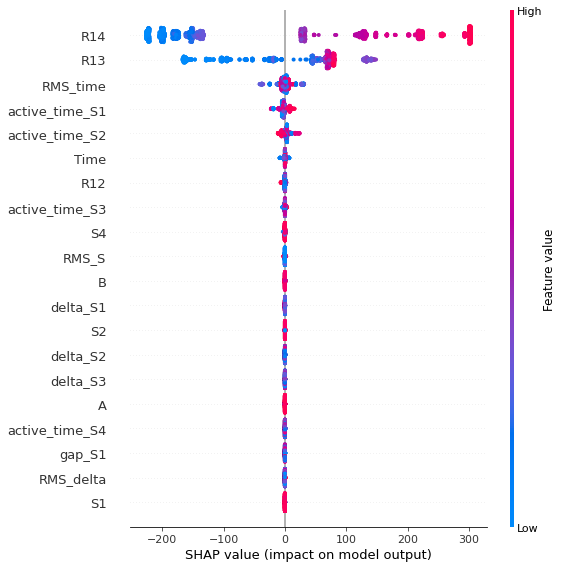

In [27]:
shap.summary_plot(shap_values_x, df_train_val[simple_features])

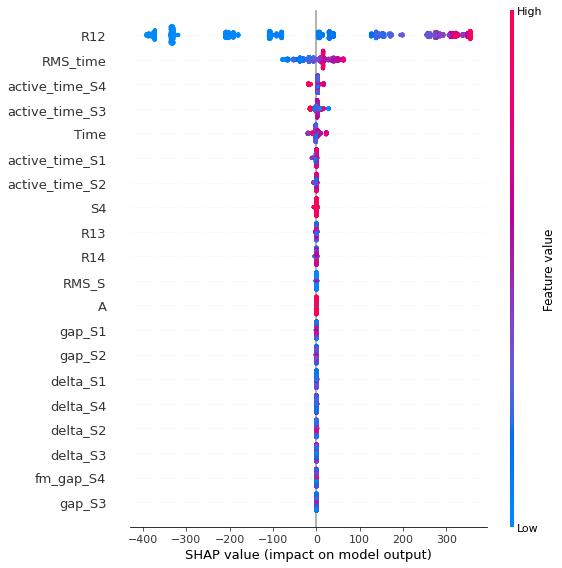

In [28]:
shap.summary_plot(shap_values_y, df_train_val[simple_features])

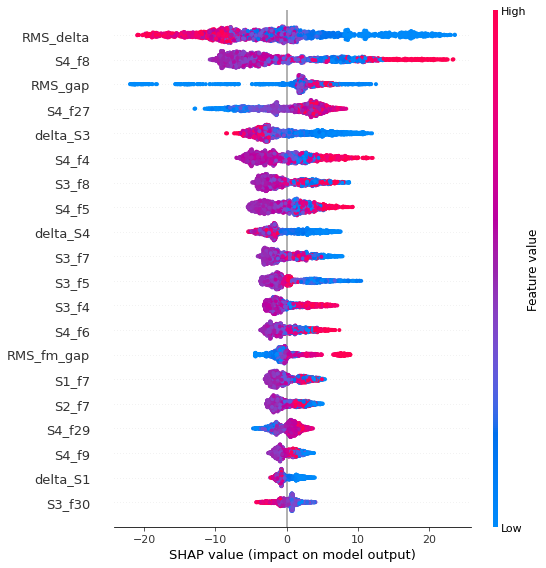

In [29]:
shap.summary_plot(shap_values_m, df_train_val[m_features])

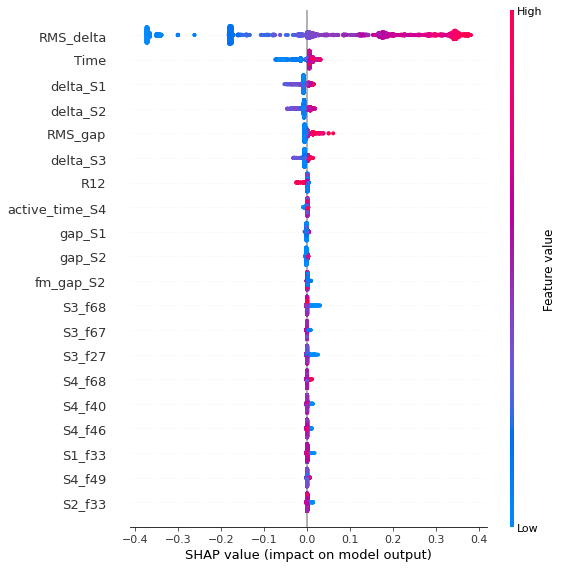

In [30]:
shap.summary_plot(shap_values_v, df_train_val[v_features])